In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import mne
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Takes string with file path as argument (eg. "/files/file.edf.seizure)
#Returns array on the format [1st seizure start time, 1st seizure start time in samples, 1st seizure end time, 1st seizure end time in samples, ...... , nth seizure start time, nth seizure start time in samples, nth seizure end time, nth seizure end time in samples]

def openSeizure(file):
    data = []
    with open(file,"rb") as f:
        buf = []
        byte = f.read(1)
        i = 0
        while byte:
            byte = f.read(1)
            if len(buf)<4:
                buf.append(byte)
            else:
                buf = buf[1:] #throw away oldest byte
                buf.append(byte) #append new byte to end.
            i = i+1
            #print(byte)

            if buf ==[b'\x01', b'\x00',b'\x00',b'\xec']: #0x010000ec appears to be a control sequence of some sort, signifying beginning of seizure data
                while byte:
                    byte = f.read(1) #next byte should be msb of seizure offset in seconds
                    if byte == b'':
                        continue #if byte is empty we've reached end of file
                    data.append(byte)
                    f.seek(2,1) #skip over next 2 bytes, they seem unimportant
                    byte = f.read(1)#this byte should be lsb of seizure offset in seconds
                    data.append(byte)
                    f.seek(7,1)#skip over next 7 bytes, again they seem unimportant
                    byte = f.read(1)#this should be the length of seizure in seconds
                    data.append(byte)
                    f.seek(4,1)#skip over next 4 bytes, if there are more seizures, looping should handle them.
                continue # once we've finished reading the seizures, we're finished with the file

        #print(data)
    legible_data = []
    i = 0
    currentTimePointer = 0 #the time points seem to be in offsets from last event for some godforsaken reason so this is for keeping current time
    while i<len(data):
        startTimeSec = data[i] + data[i+1]
        lengthSecInt = int.from_bytes(data[i+2], "big")
        startTimeSecInt = int.from_bytes(startTimeSec, "big") #get ints from parsed bytes
        currentTimePointer = currentTimePointer + startTimeSecInt #increment current time by start seizure event offset
        legible_data.append(currentTimePointer) #add current time to array
        legible_data.append(currentTimePointer*256) #convert seconds to samples
        currentTimePointer = currentTimePointer + lengthSecInt #increment current time by end of the seizure event offset
        legible_data.append(currentTimePointer) #add current time to array
        legible_data.append(currentTimePointer*256) #convert seconds to samples
        i = i+3 #weve got 3 datapoints per seizure so just move to the next one
    print(file)#print the file path for clarity
    print(legible_data)#print the datapoints for clarity
    return legible_data
#some test code, disregard
#openSeizure("chb04_05.edf.seizures")
#openSeizure("chb04_08.edf.seizures")
#openSeizure("chb04_28.edf.seizures")
#openSeizure("chb17b_63.edf.seizures")

In [4]:
file = "data\\chb01\\chb01_03.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from C:\Users\Fabian\PycharmProjects\pythonProject\data\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Fabian\AppData\Local\Temp\ipykernel_2544\3572184683.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


In [5]:
print(raw_data[0].size)
print(raw_data.size/raw_data[0].size)

921600
23.0


In [8]:
openSeizure("data/chb01/chb01_04.edf.seizures")

data/chb01/chb01_04.edf.seizures
[1467, 375552, 1494, 382464]


[1467, 375552, 1494, 382464]

data/chb01/chb01_04.edf.seizures
[1467, 375552, 1494, 382464]


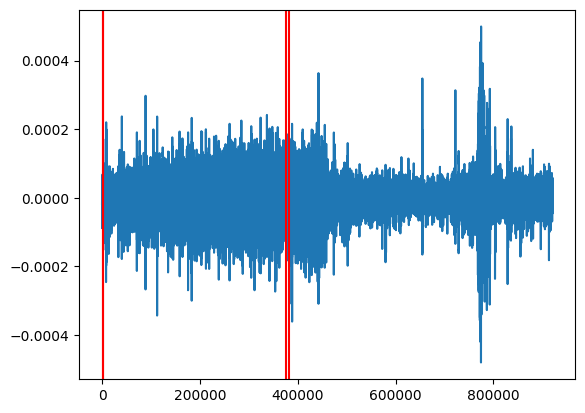

In [14]:
time = range(0,raw_data[0].size)
plt.plot(time,raw_data[0])
xcoords = openSeizure("data/chb01/chb01_04.edf.seizures")
for xc in xcoords:
    plt.axvline(x=xc, color='r')